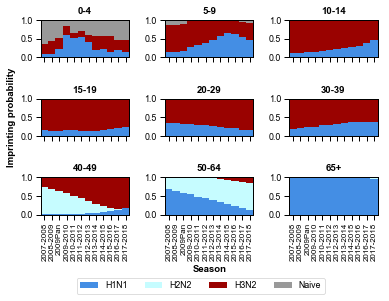

In [1]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

sns.set_context('paper')
rcParams['font.sans-serif'] = 'arial'
imprinting_df = pd.read_csv('../data/imprinting_function_birth_year.csv', index_col=('Season', 'Birth_year'))
demo_df = pd.read_csv('../data/demography_by_age_extended.csv')

age_groups =((0, 4),
             (5, 9),
             (10, 14),
             (15, 19),
             (20, 29),
             (30, 39),
             (40, 49),
             (50, 64),
             (65, 100))

def age_to_age_group(age, age_groups):
    ag = np.nan
    for lb, ub in age_groups:
        if age >= lb and age <= ub:
            ag = '-'.join((str(lb), str(ub)))
            break
    return ag

def season_to_label(season):
    if season == '2009.5':
        l = '2009Pan'
    else:
        l = str(int(float(season)) - 1) + '-' + str(int(float(season)))
    return l

pal = sns.xkcd_palette(['dark sky blue', 'light sky blue', 'deep red']).as_hex() + ['#999999']



for index, row in demo_df.iterrows():
    y1 = row.y1
    y2 = row.y2
    f1 = row.f1
    f2 = row.f2
    age = row.Age
    season = row.Season
    
    if season >= 2008:
        i_h1_1 = i_h2_1 = i_h3_1 = i_n_1 = 0
        i_h1_2 = i_h2_2 = i_h3_2 = i_n_2 = 0
        if season > 2007 and age <= 100:
            if y1 >= 1918:
                i_h1_1 = imprinting_df.loc[(season, y1), 'H1']
                i_h2_1 = imprinting_df.loc[(season, y1), 'H2']
                i_h3_1 = imprinting_df.loc[(season, y1), 'H3']
                i_n_1 = 1 - (i_h1_1 + i_h2_1 + i_h3_1)
            if y2 >= 1918:
                i_h1_2 = imprinting_df.loc[(season, y2), 'H1']
                i_h2_2 = imprinting_df.loc[(season, y2), 'H2']
                i_h3_2 = imprinting_df.loc[(season, y2), 'H3']
                i_n_2 = 1 - (i_h1_2 + i_h2_2 + i_h3_2)

            # Correction since we're just ignoring people who were born before 1918
            if y2 < 1918:
                f1 = 1.0
                f2 = 0.0

            if y1 >=1918 or y2 >=1918:
                i_h1 = i_h1_1 * f1 + i_h1_2 * f2
                i_h2 = i_h2_1 * f1 + i_h2_2 * f2
                i_h3 = i_h3_1 * f1 + i_h3_2 * f2
                i_n = i_n_1 * f1 + i_n_2 * f2
                pop = row.Population * f1 + row.Population * f2
                demo_df.loc[index, 'H1'] = i_h1 * pop
                demo_df.loc[index, 'H2'] = i_h2 * pop
                demo_df.loc[index, 'H3'] = i_h3 * pop
                demo_df.loc[index, 'naive'] = i_n * pop
                demo_df.loc[index, 'age_group'] = age_to_age_group(age, age_groups)
plot_df = demo_df[~np.isnan(demo_df.H1)].copy()

plot_df['H1N1'] = plot_df['H1']
plot_df['H2N2'] = plot_df['H2']
plot_df['H3N2'] = plot_df['H3']
plot_df['Naive'] = plot_df['naive']

for ag, agdf in plot_df.groupby('age_group'):
    a1 = int(ag.split('-')[0])
    subplot = 1
    for lb, ub in age_groups:
        if lb == a1:
            break
        else:
            subplot += 1
    plt.subplot(3, 3, subplot)
    temp = agdf.copy()
    agg = agdf.groupby('Season')
    agg = agg.sum()
    agg = agg.divide(agg.Population, axis=0)
    agg.plot.bar(y=['H1N1', 'H2N2', 'H3N2', 'Naive'],
                 stacked=True,
                 width=1,
                 color=pal,
                 ax=plt.gca(),
                 legend = False)
    ticks, labels = plt.xticks()
    plt.gca().set_xlabel('')
    if subplot not in range(len(age_groups)-2 , len(age_groups) + 1):
        plt.xticks(ticks, [])
    else:
        new_labels = [season_to_label(l.get_text()) for l in labels]
        plt.xticks(ticks, new_labels, size=8, rotation=90)#, ha='right')
    
    if subplot == 4:
        plt.ylabel('Imprinting probability', weight='bold')
        
    if subplot == 8:
        plt.gca().set_xlabel('Season', weight='bold')
        
    if ag != '65-100':
        plt.title(ag, weight='bold')
    else:
        plt.title('65+', weight='bold')

    plt.xlim(-0.5, len(agg) - 0.5)
    plt.ylim(0, 1)


plt.gcf().set_size_inches(5.5, 4)

plt.tight_layout()
plt.legend(loc='center',
           bbox_to_anchor=(-1, -1.9),
           ncol=4)

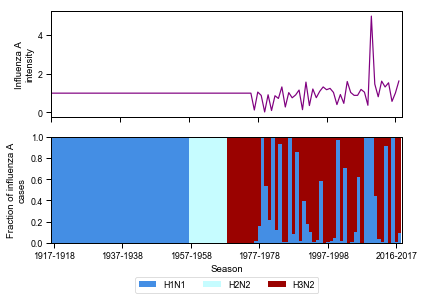

In [2]:
df = pd.read_csv('../data/Intensity_and_Frequency.csv')

def season_to_season_label(s):
    if s != 2009.5:
        l = str(int(s) - 1) + '-' + str(int(s))
    else:
        l = '2009Pan'
    return l

df['Season'] = df.season_float.apply(season_to_season_label)
df['H1N1'] = df.H1N1_fraction
df['H3N2'] = df.H3N2_fraction
df['H2N2'] = df.H2N2_fraction
df = df[df.season_float < 2019]
df = df.sort_values('Season')
plt.subplot(2,1,1)
df.plot(x='Season', y='Intensity', legend=False, ax=plt.gca(), color='purple')
ticks, labels = plt.xticks()
newticks = range(0, 102,20)
newlabels = [list(df.Season)[i] for i in newticks]
plt.xticks(newticks, [])
plt.xlim(0, 102)
plt.ylabel('Influenza A\nintensity')
plt.xlabel('')

plt.subplot(2,1,2)
pal = sns.xkcd_palette(['dark sky blue', 'light sky blue', 'deep red']).as_hex()
sns.set_palette(pal)
df.plot.bar(x='Season', y=['H1N1', 'H2N2', 'H3N2'], ax=plt.gca(), stacked=True, width=1)
plt.ylabel('Fraction of influenza A\ncases')
plt.ylim(0, 1)
plt.xticks(newticks, newlabels, rotation=0)
plt.tight_layout()
plt.legend(loc='center', ncol = 3, bbox_to_anchor=(0.5, -0.4))

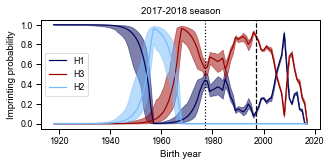

In [3]:
all_dfs = []
for trial in range(0, 1000):
    f = '../data/sample_ILI/imprinting_probs_%s.csv'%trial
    df = pd.read_csv(f)
    all_dfs.append(df)
    
df = pd.concat(all_dfs)
df = df.dropna()

min_rows = []
max_rows = []
for params, pdf in df.groupby(['Season', 'Birth_year']):
    max_rows.append(pdf[pdf.H1 == max(pdf.H1)].iloc[0, ])
    min_rows.append(pdf[pdf.H1 == min(pdf.H1)].iloc[0, ])

maxdf = pd.DataFrame(max_rows)
mindf = pd.DataFrame(min_rows)
plotdf = df[(df.Season == 2018)]

maxes = plotdf.groupby('Birth_year').max().reset_index()
mins = plotdf.groupby('Birth_year').min().reset_index()
upper = plotdf.groupby('Birth_year').quantile(.975).reset_index()
lower = plotdf.groupby('Birth_year').quantile(.025).reset_index()
median = plotdf.groupby('Birth_year').quantile(.50).reset_index()

plt.plot()
pal = sns.xkcd_palette(['dark blue', 'sky blue', 'deep red']).as_hex()

ax = plt.gca()
median.plot(x='Birth_year', y='H1', ax=ax, color=pal[0])
ax.fill_between(x=maxes.Birth_year, y1=maxes.H1, y2=mins.H1, alpha=0.5, color=pal[0])

median.plot(x='Birth_year', y='H3', ax=ax, color=pal[2])
ax.fill_between(x=maxes.Birth_year, y1=maxes.H3, y2=mins.H3, alpha=0.5, color=pal[2])

median.plot(x='Birth_year', y='H2', ax=ax, color=pal[1])
ax.fill_between(x=maxes.Birth_year, y1=maxes.H2, y2=mins.H2, alpha=0.5, color=pal[1])

plt.xlabel('Birth year')
plt.ylabel('Imprinting probability')
plt.title('2017-2018 season')
plt.gca().axvline(x=1997, color='black', linestyle='--')
plt.gca().axvline(x=1977, color='black', linestyle=':')

plt.gcf().set_size_inches(5,2)
